In [313]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# import os
# os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async" # this seems to be highly important for totally utilizing your GPU's memory, but it also breaks the profiler's memory breakdown
# note that GradientTape needs several times the memory needed to compute the fidelity of a single circuit
import tensorflow as tf
import numpy as np
import qutip as qt
from bingo.optimizer.tf_adam_optimizer import AdamOptimizer
from bingo.gate_sets import GRAPETimeDomain
from bingo.optimizer.GateSynthesizer import GateSynthesizer
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [314]:
q_dim = 2
c_dim = 5
DAC_time_resolution = 1
fock = 1

# In GHz = cycles / ns
anharm = -.180*2*np.pi
chi = -4e-3*2*np.pi
drive = D = 2 * np.pi * 1e-3

a = qt.tensor(qt.destroy(c_dim), qt.qeye(q_dim))
b = qt.tensor(qt.qeye(c_dim), qt.destroy(q_dim))
ad = a.dag()
bd = b.dag()
H0 = (anharm/2) * bd * bd * b * b
H0 += (chi) * ad * a * bd * b
Hcs = [D*(b + bd), 1j*D*(b - bd), D*(a + ad), 1j*D*(a - ad)] # I, Q, I, Q

init_states = [
    qt.tensor(qt.basis(c_dim, 0), qt.basis(q_dim, 0))
]

final_states = [
    qt.tensor(qt.basis(c_dim, fock), qt.basis(q_dim, 0))
]

In [315]:
# We initialize the gateset here
gate_set_params = {
    'H_static' : H0,
    'H_control' : Hcs,
    'control_delta_t' : 10,
    'interpolation_ratio' : 5,
    'inplace' : False, # true uses less memory, but is slower. Just use false
    'scale' : 1.0, # range of DAC amplitudes for initial random waves
    'pulse_len_ns': 1000,
    
}

GRAPE_gate_set = GRAPETimeDomain(**gate_set_params)

control_delta_t: 10.000 num_control_pts: 100 pulse_len_ns: 1000.000
              simulation_interpolation_ratio: 5 simulation_delta_t: 2.000 num_simulation_pts: 500
              fft_pad_length:200 ringup_sigma_ns: 20.000 ringup_len: 10


In [316]:
synth_params = {
    'gateset':GRAPE_gate_set,
    'N_blocks': 100, # note that the length of the pulse is number of control points
    'N_multistart' : 10, #Batch size (number of circuit optimizations to run in parallel)
    'epochs' : 600, #number of epochs before termination
    'epoch_size' : 5, #number of adam steps per epoch
    'learning_rate' : 0.1, #adam learning rate
    'term_fid' : 0.999, #0.995, #terminal fidelitiy
    'dfid_stop' : 1e-6, #stop if dfid between two epochs is smaller than this number
    'initial_states' : init_states, #qubit tensor oscillator, start in |g> |0>
    'target_states' : final_states, #end in |e> |target>.
    'name' : 'GRAPE Fock %d' % fock, #name for printing and saving
    'coherent' : True,
    'filename' : None, #if no filename specified, results will be saved in this folder under 'name.h5'
}
gatesynth = GateSynthesizer(**synth_params)

In [317]:
#create optimization object. 
#initial params will be randomized upon creation
opt = AdamOptimizer(gatesynth)

#print optimization info. this lives in gatesynth, since we eventually want to fully abstract away the optimizer
gatesynth.best_fidelity()

0.013398511

In [319]:
#run optimizer.
#note the optimizer can be stopped at any time by interrupting the python consle,
#and the optimization results will still be saved and part of the opt object.
#This allows you to stop the optimization whenever you want and still use the result.
# Note that you will not want to use the performance profiler while using 'inplace' mode. You will run out of memory
opt.optimize()#logdir='logs')

Start time: 2022-09-13 18:44:12
 Epoch: 12 / 600 Max Fid: 0.999109 Avg Fid: 0.997280 Max dFid: 0.010669 Avg dFid: 0.002854 Elapsed time: 0:00:24.770024 Expected remaining time: 0:20:13.731167

 Optimization stopped. Term fidelity reached.

N_blocks: 100
optimization_type: state transfer
optimization_masks: {'I0': None, 'Q0': None, 'I1': None, 'Q1': None}
target_unitary: None
expectation_operators: None
target_expectation_values: None
N_multistart: 10
term_fid: 0.999
dfid_stop: 1e-06
learning_rate: 0.1
epoch_size: 5
epochs: 600
name: GRAPE Fock 1
filename: None
comment: 
coherent: True
timestamps: ['2022-09-13 18:39:12', '2022-09-13 18:43:59', '2022-09-13 18:44:12']
do_prints: True
filename: GRAPE Fock 1.h5

Best circuit parameters found:
I0:    tf.Tensor(
[ 0.     +0.j -0.00733+0.j -0.03317+0.j -0.07957+0.j -0.14136+0.j
 -0.20417+0.j -0.24631+0.j -0.24679+0.j -0.19695+0.j -0.10863+0.j
 -0.01214+0.j  0.06726+0.j  0.11243+0.j  0.11339+0.j  0.07102+0.j
 -0.00229+0.j -0.08527+0.j -0.15329+

'2022-09-13 18:44:12'

In [326]:
import h5py
f = h5py.File('GRAPE Fock 1.h5', 'r')
pulse_obj = f[list(f.keys())[len(list(f.keys())) - 1]] # get the latest key
fids = pulse_obj['fidelities']
# list(f.keys())
pulse_idx = np.argmax(np.amax(fids, axis=0))
controls = []
for k in range(1):
    controls.append(np.array(pulse_obj['I' + str(k)][-1, pulse_idx, :]))
    controls.append(np.array(pulse_obj['Q' + str(k)][-1, pulse_idx, :]))
DAC_time_resolution = 2 # in ns
pulse_len = controls[0].shape[0] * DAC_time_resolution
times = np.arange(pulse_len, step = DAC_time_resolution, dtype=float)
fids[-1, pulse_idx]

0.9991089

/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Drive / $\\chi$')

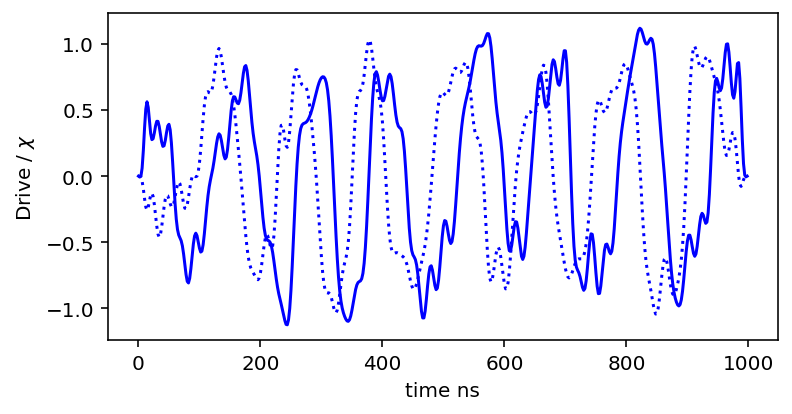

In [327]:
plt.figure(figsize=(6,3))
plt.plot(times, controls[0], 'b-')
plt.plot(times, controls[1], 'b:')
plt.xlabel(r'time ns')
plt.ylabel(r'Drive / $\chi$')

Text(0, 0.5, 'Mag')

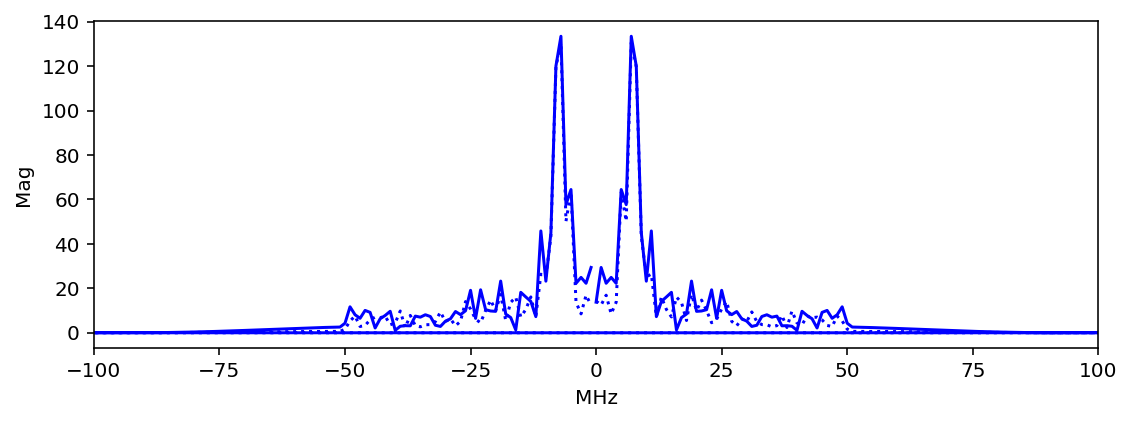

In [323]:
plt.figure(figsize=(9,3))
plt.plot(np.fft.fftfreq(len(controls[0]), DAC_time_resolution) * 1000, np.abs(np.fft.fft(controls[0])), 'b-')
plt.plot(np.fft.fftfreq(len(controls[0]), DAC_time_resolution) * 1000, np.abs(np.fft.fft(controls[1])), 'b:')
plt.xlabel(r'MHz')
plt.xlim(-100, 100)
plt.ylabel(r'Mag')
# plt.yscale('log')